This notebook is by Anastasia Ruzmaikina.

In this notebook we use the Decision Tree Classifier to classify a wine as 'high quality' or 'low quality' based on eleven attributes such as density, sulfates, alhohol, fixed acidity etc. We use a data set of 6496 wines. 

It turns out that if we fine tune the parameters, we can achieve a 74.2% accuracy in predicting the quality of the wine using the Decision Tree Classifier.

Using the Support Vector Machine, we can predict if the wine is high quality with accuracy 75.4%.

In [169]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

First we load the data and understand the data.

In [84]:
wine = pd.read_csv('wine.csv')

In [85]:
wine.shape

(6497, 14)

In [86]:
wine.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,high_quality
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red,0
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,red,0
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,red,0
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,red,1
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red,0


The column 'Unnamed: 0' carries no new information, so we drop it.

In [87]:
wine.drop(['Unnamed: 0'], axis=1, inplace=True)

We can look at the column statistics.

In [88]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.633061
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.482007
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


Now we proceed with the exploratory data analysis.

In [89]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  color                 6497 non-null   object 
 12  high_quality          6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


The column 'color' is categorical, so we do a one hot encoding to get two numerical columns: 'color_red' and 'color_white'.

In [90]:
color_dummies= pd.get_dummies(data=wine, columns=['color'])
wine = color_dummies

In [91]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,0,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,0,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,0,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,0,1


We take a look at the target column.

In [92]:
# The high_quality is the target column y.
wine.high_quality.value_counts()

1    4113
0    2384
Name: high_quality, dtype: int64

We can plot a pie chart for the distribution of values in the 'high_quality' column.

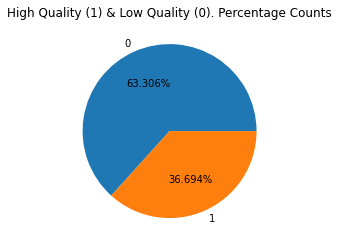

In [93]:
# get the set of distinct classes
labels = wine.high_quality.unique()

# get the count of each class
sizes = wine.high_quality.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('High Quality (1) & Low Quality (0). Percentage Counts')
plt.show()

We look at the 'high_quality' column as a function of 'density'.

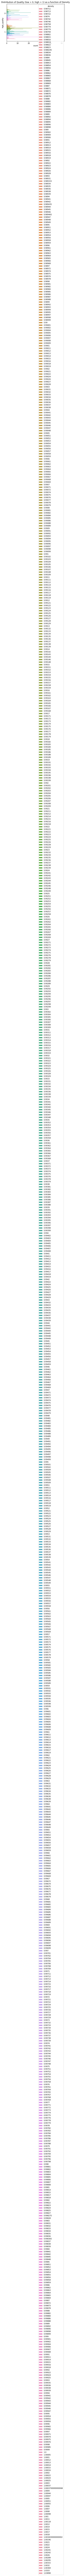

In [95]:
sns.countplot(y='high_quality', data=wine, hue='density')
plt.title("Distribution of Quality (low = 0, high = 1) as a function of Density")
plt.show()

We look at 'high_quality' column as a function of 'alcohol'.

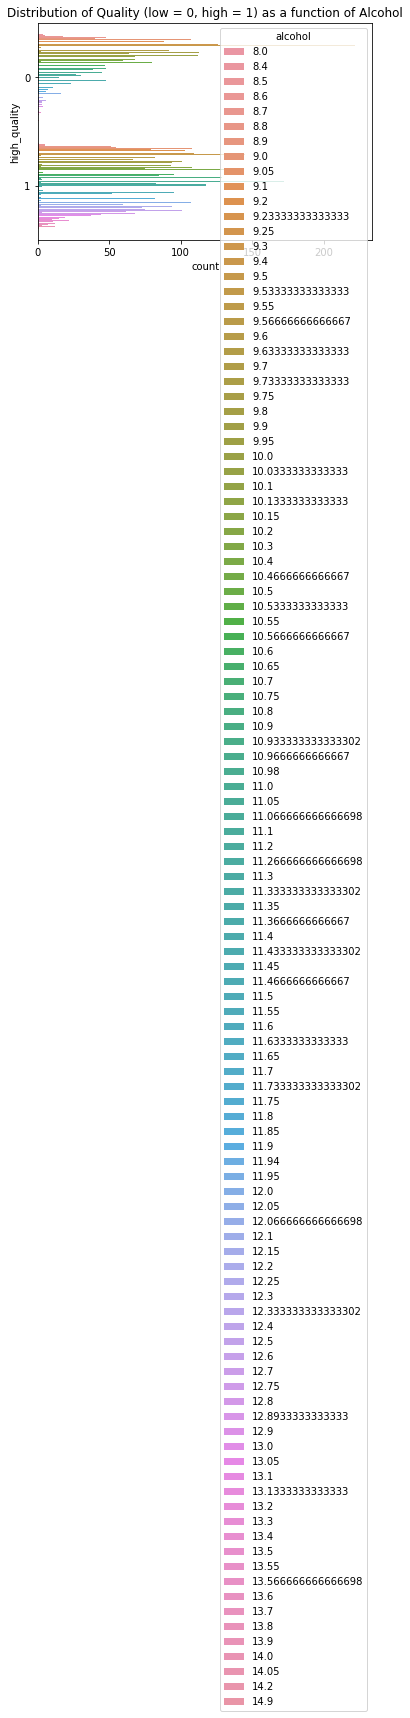

In [96]:
sns.countplot(y='high_quality', data=wine, hue='alcohol')
plt.title("Distribution of Quality (low = 0, high = 1) as a function of Alcohol")
plt.show()

We look at the 'high_quality' column as a function of 'pH'.

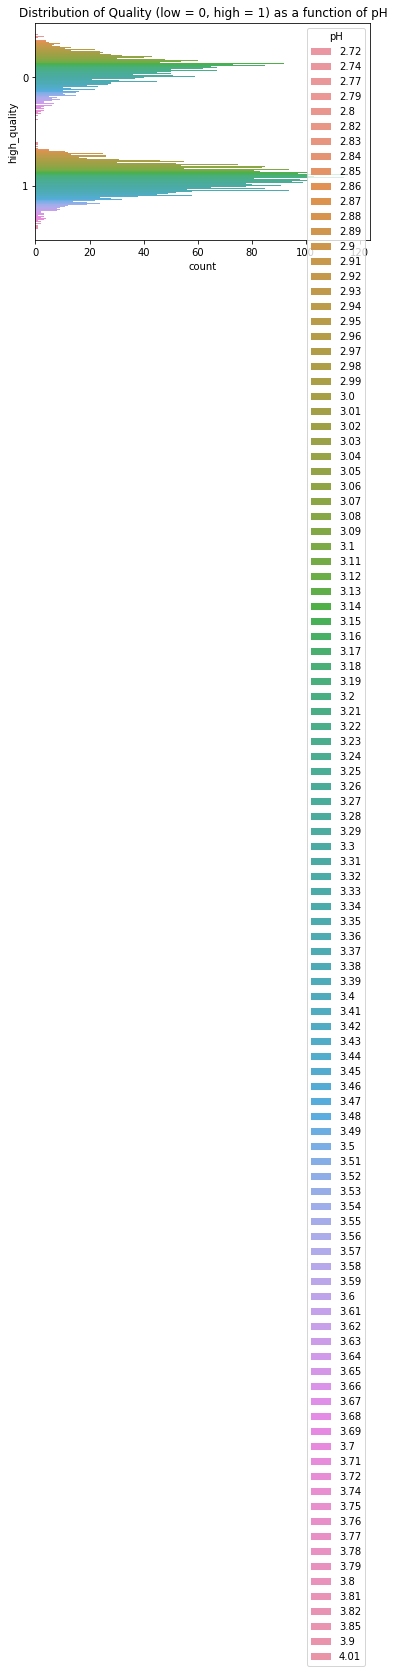

In [97]:
sns.countplot(y='high_quality', data=wine, hue='pH')
plt.title("Distribution of Quality (low = 0, high = 1) as a function of pH")
plt.show()

We look at the 'high_quality' column as a function of 'sulphates'.

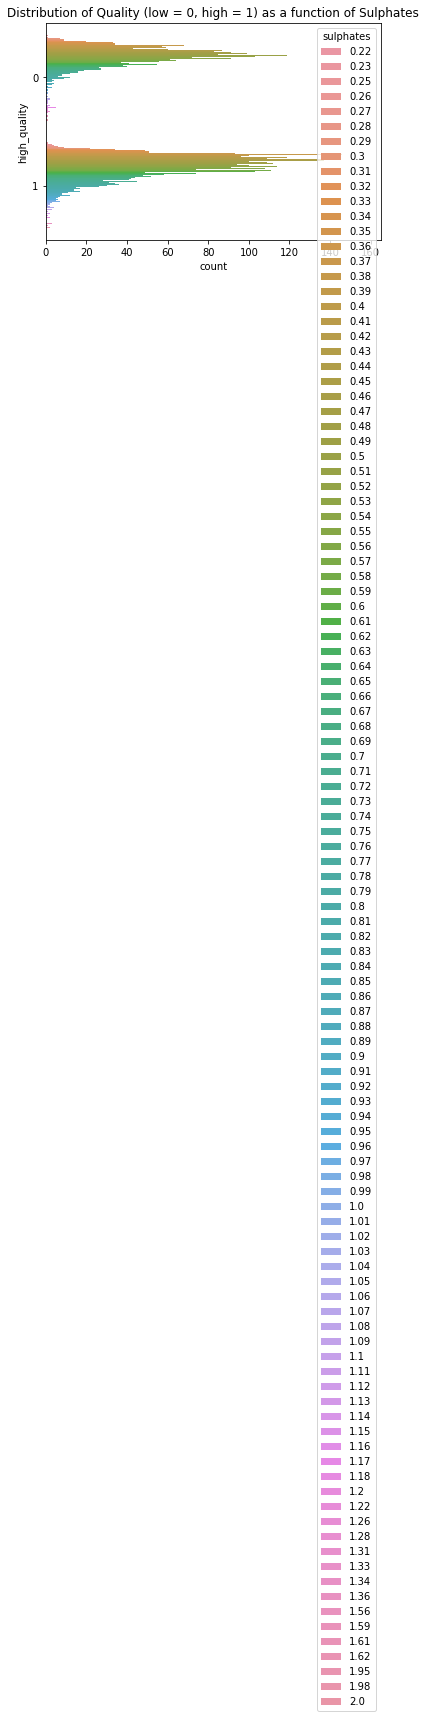

In [99]:
sns.countplot(y='high_quality', data=wine, hue='sulphates')
plt.title("Distribution of Quality (low = 0, high = 1) as a function of Sulphates")
plt.show()

Data Preprocessing.

In [37]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'high_quality', 'color_red',
       'color_white'],
      dtype='object')

First we rescale the data using the Standard Scaler to make sure that the columns with higher values do not have a disproportionate effect on the target variable. 

We assign the first eleven columns a predictors X, and the 12th column 'high_quality' as a target variable y.

In [108]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
wine.iloc[:, 0:11] = StandardScaler().fit_transform(wine.iloc[:, 0:11])
data_matrix = wine.values

# X: feature matrix (for this analysis, we exclude the 'high_value' variable from the dataset)
X = data_matrix[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]]

# y: labels vector
y = data_matrix[:, 11]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

wine.head()

X.shape= (6497, 13) y.shape= (6497,)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality,color_red,color_white
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,0,1,0
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,0,1,0
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,0,1,0
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,1,1,0
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,0,1,0


We split the data into the training set and the test set.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (4547, 13) Y_train.shape= (4547,)
X_test.shape= (1950, 13) Y_test.shape= (1950,)


In [110]:
X_train

array([[-0.01053015,  0.07215247, -0.03962261, ...,  0.12985765,
         0.        ,  0.11838474],
       [ 0.01291513,  0.16537786, -0.09272478, ..., -0.07538551,
         0.09064952,  0.        ],
       [-0.01442952, -0.05259747,  0.11441724, ..., -0.07224917,
         0.        ,  0.08687814],
       ...,
       [ 0.02831043, -0.08673205,  0.00089735, ..., -0.09533464,
         0.        ,  0.09540016],
       [-0.02159846,  0.00816314, -0.13301837, ..., -0.08633665,
         0.        ,  0.13004131],
       [-0.04316135, -0.01609408,  0.06616879, ...,  0.18166882,
         0.        ,  0.13472328]])

Model Building

Parameters

1.max_depth: (int, default=None) This is used to select how deep you want to make each tree in the forest. The deeper the tree, the more splits it has, and it captures more information about the data.

2.criterion :{“Gini,” “entropy”}, default=” Gini”: Measures the quality of each split. “Gini” uses the Gini impurity while “entropy” makes the split based on the information gain.

3.splitter:{“best”, “random”}, default=”best” The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

4.min_samples_split: (int or float, default=2:) This specifies the minimum number of samples that must be present from your data for a split to occur.



Decision Tree Model 1:
    
We import the Decision Tree Classifier and build the first model. We take the max tree depth to be 4 and the splitting criterion to be based on the Gini Impurity.

In [112]:
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35, criterion='gini',
                                splitter='random')

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  0.00473


We compare the predicted values of y using X_test with y_test and calculate ROC-AUC score as well as the Accuracy Score.

In [114]:
# run inference and compute the probabilities of the test samples 
# to belong to the class of high-quality wines
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))
print('The Accuracy Score:', sklearn_dt.score(X_test,y_test))

[Scikit-Learn] ROC-AUC score : 0.712
The Accuracy Score: 0.6528205128205128


Predict values using trained model 1

In [117]:
# Predicting the test and trained values
y_train_pred = sklearn_dt.predict(X_train)
y_test_pred = sklearn_dt.predict(X_test)
print('Prediction of training data 0:100 is:', y_train_pred[0:100])
print('Prediction of test data 0:100 is:', y_test_pred[0:100])

Prediction of training data 0:100 is: [1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 1. 1.]
Prediction of test data 0:100 is: [1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 0. 1.]


Model 1 Performance.

We measure the performance using the confusion matrix and the accuracy score.

In [118]:
# Importing all the required metrics for calculating Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix

In [119]:
confusion_matrix(y_train, y_train_pred)

array([[1230,  438],
       [1077, 1802]])

In [120]:
confusion_matrix(y_test, y_test_pred)

array([[481, 235],
       [442, 792]])

In [121]:
# The Accuracy_score
accuracy_score(y_test, y_test_pred)

0.6528205128205128

Decision Tree Model 2

We increase max depth to 5, use 'entropy' as a splitting criterion.

In [122]:
#storing the Decision tree classifier into clftree2
clftree2 = DecisionTreeClassifier(max_depth = 5, criterion = "entropy",
                                  splitter = "best")
clftree2.fit(X_train, y_train)
clftree2.score(X_test,y_test)

0.742051282051282

Decision Tree Model 3

We increase max depth to 6, use 'gini' as a splitting criterion.

In [124]:
#storing the Decision tree classifier into clftree3
clftree3 = DecisionTreeClassifier(max_depth = 6, criterion = "gini", 
                                  splitter = "random")
clftree3.fit(X_train, y_train)
clftree3.score(X_test,y_test)

0.7241025641025641

Decision Tree Model 4

We increase max depth to 6, use 'entropy' as a splitting criterion.

In [125]:
#storing the Decision tree classifier into clftree4
clftree4 = DecisionTreeClassifier(max_depth = 6, criterion = "entropy", 
                                  splitter = "best")
clftree4.fit(X_train, y_train)
clftree4.score(X_test,y_test)

0.7302564102564103

Decision Tree Model 5

We increase max depth to 7, use 'entropy' as a splitting criterion.

In [126]:
#storing the Decision tree classifier into clftree5
clftree5 = DecisionTreeClassifier(max_depth = 7, criterion = "entropy", 
                                  splitter = "best")
clftree5.fit(X_train, y_train)
clftree5.score(X_test,y_test)

0.7302564102564103

Hyperparameter Tuning using GridSearchCV:   

In order to find optimal parameters, we do a grid search over different parameter values.

Parameters
 
1.max_depth: (int, default=None) This is used to select how deep you want to make each tree in the forest. The deeper the tree, the more splits it has, and it captures more information about the data.

2.criterion :{“Gini,” “entropy”}, default=” Gini”: Measures the quality of each split. “Gini” uses the Gini impurity while “entropy” makes the split based on the information gain.

3.splitter:{“best”, “random”}, default=”best” The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

4.min_samples_split: (int or float, default=2:) This specifies the minimum number of samples that must be present from your data for a split to occur.

One traditional and popular way to perform hyperparameter tuning is by using an Exhaustive Grid Search from Scikit learn. This method tries every possible combination of each set of hyper-parameters. Using this method, we can find the best set of values in the parameter search space. This usually uses more computational power and takes a long time to run since this method needs to try every combination in the grid size.



In [127]:
# Importing GridsearchCV
from sklearn.model_selection import GridSearchCV

In [128]:
# Assigning all the parameters of Decision tree classifier for  parameters variable
parameters ={
    'max_depth': [3,4,5,6,7,8,9,11,13],
    'criterion':['gini','entropy'],
    'splitter':['random','best'],
    'min_samples_split':[2,4,6,7,8,9],
    }

In [129]:
# Assigning parameters for GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(),parameters, scoring='accuracy', verbose=2, cv=3,)

In [130]:
# Fitting the model into gridsearchCV
grid_result= grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, min_samples_split=4, splitter=best; total time=   

[CV] END criterion=gini, max_depth=5, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_split=8, s

[CV] END criterion=gini, max_depth=7, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=8, min_samples_split=4,

[CV] END criterion=gini, max_depth=11, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=11, min_samples

[CV] END criterion=entropy, max_depth=4, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, 

[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, 

[CV] END criterion=entropy, max_depth=9, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_

[CV] END criterion=entropy, max_depth=13, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=8, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=13, min_samples_split=9, splitter=best; total time=   0.0s


best_index_: (int) The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.


In [131]:
print('Best index: ', grid_result.best_index_)

Best index:  97


best_params (dict): Parameter setting that gave the best results on the hold out data.


In [70]:
print('Best Params: ', grid_result.best_params_)

Best Params:  {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 9, 'splitter': 'best'}


best_score (float) : Mean cross-validated score of the best_estimator

For multi-metric evaluation, this is present only if refit is specified.

This attribute is not available if refit is a function.

In [132]:
print('Best Score: ', grid_result.best_score_)

Best Score:  0.7420292820838812


Conclusion: Using the Decision Tree Classifier, we can predict if the wine is high quality with accuracy 74.2%.

We can repeat the same using Support Vector Machine model.

In [159]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# instatiate a scikit-learn SVM model
# to indicate the class imbalance at fit time, set class_weight='balanced'
# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  0.02


In [160]:
# run inference using the Scikit-Learn model
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))


[Scikit-Learn] ROC-AUC score:   0.798


In [161]:
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

# import the hinge_loss metric from scikit-learn
from sklearn.metrics import hinge_loss

# evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_sklearn))

# the two models should give the same Hinge loss

[Scikit-Learn] Hinge loss:   0.635


In [162]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [163]:
print(format(X_trainset.shape))
print(y_trainset.shape)
print(X_testset.shape)
print(y_testset.shape)

(4547, 13)
(4547,)
(1950, 13)
(1950,)


In [164]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
Tree

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [165]:
Tree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [166]:
predTree = Tree.predict(X_testset)

In [167]:
print (predTree [0:50])
print (y_testset [0:50])


[1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.
 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0.]


In [168]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.7538461538461538


Conclusion: Using the Support Vector Machine model, we can increase the accuracy of the prediction whether the wine is high quality to 75.4%.

In [172]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

We now show a graph of what the decision tree looks like.

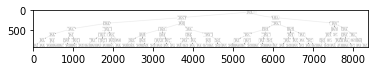

In [176]:
import pandas
from sklearn import tree
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

#tree.plot_tree(Tree)
import graphviz
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color_red', 'color_white']
data = tree.export_graphviz(Tree, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('mydecisiontree.png')

img=pltimg.imread('mydecisiontree.png')

plt.figure(figsize=(6,6))
imgplot = plt.imshow(img)
plt.show()
